<a href="https://colab.research.google.com/github/Gunhum/PROJET_DDEFI_2025/blob/main/Projet_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installer les bibliothèques si nécessaire
!pip install yfinance pandas matplotlib seaborn requests

In [1]:
# Importer les bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import yfinance as yf

# Importation des prix & taux de change eur/dollar



In [28]:
import yfinance as yf
import pandas as pd

def download_oil_data(start="2019-01-01", end="2024-01-01", interval="1d"):
    # Télécharger les données
    assets = {
        "Brent": "BZ=F",
        "WTI": "CL=F",
        "USD/EUR": "EURUSD=X",
        "VIX": "^VIX"
    }
    data = {}
    for name, ticker in assets.items():
        df = yf.download(ticker, start=start, end=end, interval=interval)[["Close"]]
        #df.rename(columns={"Close": name}, inplace=True)
        data[name] = df.iloc[:,0]

    # Fusionner sur l'index (dates)
    oil_df = pd.concat(data.values(), axis=1)
    oil_df.columns = ['Brent', 'WTI', 'EUR/USD','VIX']
    return oil_df

# # 📌 Exécution de la fonction
# oil_prices = download_oil_data()


# # 🔹 Affichage rapide
# print(oil_prices.head())
# plt.figure(figsize=(10, 6))
# plt.plot(oil_prices.index, oil_prices["Brent"], label="Brent Crude Oil")
# plt.plot(oil_prices.index, oil_prices["WTI"], label="WTI Crude Oil")
# plt.plot(oil_prices.index, oil_prices["USD/EUR"], label="USD/EUR Exchange Rate")

# # Ajout des labels, titre et légende
# plt.title("Évolution des prix du Brent, WTI et taux de change USD/EUR (2019-2024)")
# plt.xlabel("Date")
# plt.ylabel("Prix (USD)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# # Affichage
# plt.show()


# Importation données macro

In [25]:
pip install fredapi

In [29]:
import pandas as pd
from fredapi import Fred

def download_macro_data(fred_api_key, start_date="2015-01-01"):
    fred = Fred(api_key=fred_api_key)

    indicators = {
        'GDP': 'GDP',                  # Produit Intérieur Brut (PIB)
        'CPI': 'CPIAUCSL',              # Indice des Prix à la Consommation (inflation)
        'PMI': 'IR14270'             # Indice des directeurs d'achat
    }

    macro_data = {name: fred.get_series(series_id, observation_start=start_date) for name, series_id in indicators.items()}
    macro_df = pd.DataFrame(macro_data)

    return macro_df

# 📌 Exécution de la fonction
fred_api_key = 'b26c59f3113303d98884bc26e1829e1e'
macro_data = download_macro_data(fred_api_key, start_date="2015-01-01")

# 🔹 Affichage rapide
print(macro_data.head())


                  GDP      CPI    PMI
2015-01-01  18063.529  234.747  442.5
2015-02-01        NaN  235.342  461.4
2015-03-01        NaN  235.976  439.1
2015-04-01  18279.784  236.222  440.6
2015-05-01        NaN  237.001  435.7


# Géopolitical risk

In [30]:
def get_geopolitical_risk_data():
    url = "https://www.matteoiacoviello.com/gpr_data/global.csv"
    gpr_data = pd.read_csv(url, parse_dates=["date"], index_col="date")

    return gpr_data

# 📌 Exécution
gpr_data = get_geopolitical_risk_data()

# 🔹 Affichage rapide
print(gpr_data.head())

HTTPError: HTTP Error 404: Not Found

# Importation Données EAI

In [31]:
pip install requests pandas

## Stocks de pétrole et autres produits

In [32]:
def fetch_eia_stocks(start_date: str, end_date: str) -> pd.DataFrame:

    # Définition de l'API Key et de l'URL
    EIA_API_KEY = "ssGvr7Tf6BSjXyaYPbBqVkYMFBCfHjIdMTIXvhAo"
    base_url = "https://api.eia.gov/v2/petroleum/stoc/wstk/data/"

    # Paramètres de la requête API
    params = {
        "api_key": EIA_API_KEY,
        "frequency": "weekly",  # Données hebdomadaires
        "data[0]": "value",  # Valeur des stocks en milliers de barils (MBBL)
        "facets[product][]": ["EPC0", "EPD0", "EPPK", "EPPR"],  # Produits sélectionnés
        "facets[duoarea][]": "NUS",  # Récupération consolidée pour les U.S.
        "facets[process][]": "SAE",  # Stocks finaux globaux uniquement
        "start": start_date,  # Date de début dynamique
        "end": end_date,  # Date de fin dynamique
        "offset": 0,
        "length": 5000  # Nombre maximum d'enregistrements
    }

    # Effectuer la requête API
    response = requests.get(base_url, params=params)

    # Vérifier si la requête a réussi
    if response.status_code == 200:
        data = response.json()

        # Convertir en DataFrame
        df_stocks = pd.DataFrame(data["response"]["data"])

        # Convertir la colonne 'period' en format datetime et trier
        df_stocks['period'] = pd.to_datetime(df_stocks['period'])
        df_stocks = df_stocks.sort_values(by="period")
    else:
        raise Exception(f"Erreur lors de la récupération des données : {response.status_code} {response.text}")

    # Vérifier que les colonnes essentielles sont bien présentes
    required_columns = {"period", "product-name", "value"}
    if required_columns.issubset(df_stocks.columns):

        # Pivot pour mettre chaque produit en colonne
        df_pivot_stocks = df_stocks.pivot(index="period", columns="product-name", values="value")

        # Renommer les colonnes pour éviter les espaces et faciliter la manipulation
        df_pivot_stocks.columns = [col.replace(" ", "_") + "_Stocks" for col in df_pivot_stocks.columns]

        # Réinitialiser l'index pour avoir 'period' comme colonne classique
        df_pivot_stocks.reset_index(inplace=True)

        return df_pivot_stocks
    else:
        raise Exception("Erreur : Colonnes manquantes dans df_stocks. Vérifie les noms des colonnes.")

# Exemple d'utilisation
# df = fetch_eia_stocks("2015-01-01", "2025-02-28")
# print(df.head())

## Import/Export de pétrole et autres produits

In [33]:
def fetch_eia_import_export(start_date: str, end_date: str) -> pd.DataFrame:

    # Définition de l'API Key et de l'URL de base
    EIA_API_KEY = "ssGvr7Tf6BSjXyaYPbBqVkYMFBCfHjIdMTIXvhAo"
    base_url = "https://api.eia.gov/v2/petroleum/move/wkly/data/"

    # Paramètres de la requête API
    params = {
        "api_key": EIA_API_KEY,
        "frequency": "weekly",  # Données hebdomadaires
        "data[0]": "value",  # Quantité en milliers de barils/jour (MBBL/d)
        "facets[duoarea][]": "NUS-Z00",  # Import/Export consolidé pour les U.S.
        "facets[product][]": ["EPC0", "EPD0", "EPPK", "EPPR"],  # Produits pétroliers
        "facets[series][]": [  # Séries de données pour import/export
            "WCREXUS2", "WCRIMUS2",  # Crude Oil Exports / Imports
            "WDIEXUS2", "WDIIMUS2",  # Distillate Fuel Oil Exports / Imports
            "WREEXUS2", "WREIMUS2",  # Residual Fuel Oil Exports / Imports
            "W_EPPK_IM0_NUS-Z00_MBBLD"  # Kerosene Imports
        ],
        "start": start_date,  # Date de début dynamique
        "end": end_date,  # Date de fin dynamique
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000  # Nombre maximum d'enregistrements
    }

    # Effectuer la requête API
    response = requests.get(base_url, params=params)

    # Vérifier si la requête a réussi
    if response.status_code == 200:
        data = response.json()

        # Convertir en DataFrame
        df_import_export = pd.DataFrame(data["response"]["data"])

        # Convertir la colonne 'period' en format datetime et trier
        df_import_export['period'] = pd.to_datetime(df_import_export['period'])
        df_import_export = df_import_export.sort_values(by="period")

        # Réorganiser la table pour avoir une colonne par produit et type de mouvement
        df_import_export_pivot = df_import_export.pivot(index="period", columns="series", values="value")

        # Renommer les colonnes avec des noms explicites
        rename_dict = {
            "WCREXUS2": "Crude_Oil_Exports_MBBL/D",
            "WCRIMUS2": "Crude_Oil_Imports_MBBL/D",
            "WDIEXUS2": "Distillate_Fuel_Exports_MBBL/D",
            "WDIIMUS2": "Distillate_Fuel_Imports_MBBL/D",
            "WREEXUS2": "Residual_Fuel_Exports_MBBL/D",
            "WREIMUS2": "Residual_Fuel_Imports_MBBL/D",
            "W_EPPK_IM0_NUS-Z00_MBBLD": "Kerosene_Imports_MBBL/D"
        }

        df_import_export_pivot.rename(columns=rename_dict, inplace=True)

        # Réinitialiser l'index pour garder "period" comme colonne classique
        df_import_export_pivot.reset_index(inplace=True)

        return df_import_export_pivot
    else:
        raise Exception(f"Erreur lors de la récupération des données : {response.status_code} {response.text}")


## Consommation de carburants

In [34]:
def fetch_eia_consumption(start_date: str, end_date: str) -> pd.DataFrame:
    # Définition de l'API Key et de l'URL de base
    EIA_API_KEY = "ssGvr7Tf6BSjXyaYPbBqVkYMFBCfHjIdMTIXvhAo"
    base_url = "https://api.eia.gov/v2/petroleum/cons/wpsup/data/"

    # Paramètres de la requête API
    params = {
        "api_key": EIA_API_KEY,
        "frequency": "weekly",  # Données hebdomadaires
        "data[0]": "value",  # Quantité consommée en milliers de barils/jour (MBBL/d)
        "facets[product][]": ["EPD0", "EPJK", "EPPR"],  # Produits pétroliers
        "start": start_date,  # Date de début dynamique
        "end": end_date,  # Date de fin dynamique
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000  # Nombre maximum d'enregistrements
    }

    # Effectuer la requête API
    response = requests.get(base_url, params=params)

    # Vérifier si la requête a réussi
    if response.status_code == 200:
        data = response.json()

        # Convertir en DataFrame
        df_consumption = pd.DataFrame(data["response"]["data"])

        # Convertir la colonne 'period' en format datetime et trier
        df_consumption['period'] = pd.to_datetime(df_consumption['period'])
        df_consumption = df_consumption.sort_values(by="period")

        # Réorganiser la table pour avoir une colonne par produit
        df_consumption_pivot = df_consumption.pivot(index="period", columns="product-name", values="value")

        # Renommer les colonnes avec des noms explicites
        rename_dict = {
            "Distillate Fuel Oil": "Distillate_Fuel_Consumption_MBBL/D",
            "Kerosene-Type Jet Fuel": "Kerosene_Consumption_MBBL/D",
            "Residual Fuel Oil": "Residual_Fuel_Consumption_MBBL/D"
        }

        df_consumption_pivot.rename(columns=rename_dict, inplace=True)

        # Réinitialiser l'index pour garder "period" comme colonne classique
        df_consumption_pivot.reset_index(inplace=True)

        return df_consumption_pivot
    else:
        raise Exception(f"Erreur lors de la récupération des données : {response.status_code} {response.text}")

# Exemple d'utilisation
# df = fetch_eia_consumption("2015-01-01", "2025-02-28")
# print(df.head())


## Raffinage du pétrole

In [35]:
def fetch_eia_production(start_date: str, end_date: str) -> pd.DataFrame:
    # Définition de l'API Key et de l'URL
    EIA_API_KEY = "ssGvr7Tf6BSjXyaYPbBqVkYMFBCfHjIdMTIXvhAo"
    base_url = "https://api.eia.gov/v2/petroleum/pnp/wiup/data/"

    # Paramètres de la requête API
    params = {
        "api_key": EIA_API_KEY,
        "frequency": "weekly",  # Données hebdomadaires
        "data[0]": "value",  # Quantité produite en milliers de barils/jour (MBBL/d)
        "facets[product][]": ["EPC0"],  # Pétrole brut
        "start": start_date,  # Date de début dynamique
        "end": end_date,  # Date de fin dynamique
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000  # Nombre maximum d'enregistrements
    }

    # Effectuer la requête API
    response = requests.get(base_url, params=params)

    # Vérifier si la requête a réussi
    if response.status_code == 200:
        data = response.json()

        # Convertir en DataFrame
        df_production = pd.DataFrame(data["response"]["data"])

        # Convertir la colonne 'period' en format datetime et trier
        df_production['period'] = pd.to_datetime(df_production['period'])
        df_production = df_production.sort_values(by="period")

        # Renommer la colonne pour plus de clarté
        df_production.rename(columns={"value": "Crude_Oil_refining_MBBL/D"}, inplace=True)

        # Garder uniquement les colonnes essentielles
        df_production = df_production[['period', 'Crude_Oil_refining_MBBL/D']]

        df_production["Crude_Oil_refining_MBBL/D"] = pd.to_numeric(df_production["Crude_Oil_refining_MBBL/D"], errors="coerce")
        df_production = df_production.groupby("period", as_index=False).sum()

        return df_production
    else:
        raise Exception(f"Erreur lors de la récupération des données : {response.status_code} {response.text}")

# Exemple d'utilisation
# df = fetch_eia_production("2015-01-01", "2025-02-28")
# print(df.head())


## Fusion en une table

In [36]:
def merge_eia_data(df_stocks: pd.DataFrame, df_import_export: pd.DataFrame, df_consumption: pd.DataFrame, df_production: pd.DataFrame) -> pd.DataFrame:

    df_final = df_stocks.merge(df_import_export, on="period", how="left")
    df_final = df_final.merge(df_consumption, on="period", how="left")
    df_final = df_final.merge(df_production, on="period", how="left")

    return df_final

## Fonction pour créer la table finale

In [37]:
def fetch_eia_final_table(start_date: str, end_date: str) -> pd.DataFrame:

    df_stocks = fetch_eia_stocks(start_date, end_date)
    df_import_export = fetch_eia_import_export(start_date, end_date)
    df_consumption = fetch_eia_consumption(start_date, end_date)
    df_production = fetch_eia_production(start_date, end_date)

    return merge_eia_data(df_stocks, df_import_export, df_consumption, df_production)

In [38]:
def merge_dataframes(oil_prices, macro_data, data_stock):

    # 🔹 Corriger l'index multi-niveau de oil_prices
    if isinstance(oil_prices.columns, pd.MultiIndex):
        oil_prices.columns = oil_prices.columns.droplevel(0)  # Supprimer le niveau supérieur

    # 🔹 Convertir tous les index en datetime pour un bon alignement
    oil_prices.index = pd.to_datetime(oil_prices.index)
    macro_data.index = pd.to_datetime(macro_data.index)
    data_stock['period'] = pd.to_datetime(data_stock['period'])

    # 🔹 Fusionner les DataFrames sur l'index temporel
    merged_df = oil_prices.merge(macro_data, left_index=True, right_index=True, how='outer')
    merged_df = merged_df.merge(data_stock.set_index('period'), left_index=True, right_index=True, how='outer')
    merged_df[['GDP', 'CPI', 'PMI']]=merged_df[['GDP', 'CPI', 'PMI']].fillna(method='ffill')
    final_df_cleaned = merged_df.dropna(subset=['Crude_Oil_Stocks'])
    return final_df_cleaned



In [238]:
def table_complete(start, end):
  fred_api_key = 'b26c59f3113303d98884bc26e1829e1e'
  macro_data = download_macro_data(fred_api_key, start_date=start)
  oil_prices = download_oil_data(start=start, end=end, interval="1d")
  data_stock = fetch_eia_final_table(start, end)
  #  Exécution de la fusion
  final_df = merge_dataframes(oil_prices, macro_data, data_stock)
  if "Kerosene_Imports_MBBL/D" in final_df.columns:
    final_df = final_df.drop(columns="Kerosene_Imports_MBBL/D")
  final_df = final_df.dropna().apply(pd.to_numeric, errors='coerce')
  return final_df



In [239]:
final_df =table_complete(start="2015-01-01", end="2025-01-01")
final_df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-38-9bf75c070ea9>:15: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Brent,WTI,EUR/USD,VIX,GDP,CPI,PMI,Crude_Oil_Stocks,Distillate_Fuel_Oil_Stocks,Kerosene_Stocks,...,Crude_Oil_Exports_MBBL/D,Crude_Oil_Imports_MBBL/D,Distillate_Fuel_Exports_MBBL/D,Distillate_Fuel_Imports_MBBL/D,Residual_Fuel_Exports_MBBL/D,Residual_Fuel_Imports_MBBL/D,Distillate_Fuel_Consumption_MBBL/D,Kerosene_Consumption_MBBL/D,Residual_Fuel_Consumption_MBBL/D,Crude_Oil_refining_MBBL/D
2015-01-02,56.419998,52.689999,1.208941,17.790001,18063.529,234.747,442.5,1039767,136926,2086,...,388,6856,979,265,373,227,2865,1527,425,16419.0
2015-01-09,50.110001,48.360001,1.179607,17.549999,18063.529,234.747,442.5,1045154,139851,2086,...,388,7492,979,232,373,83,3943,1553,190,15894.0
2015-01-16,47.689999,48.689999,1.163738,20.950001,18063.529,234.747,442.5,1055224,136579,1964,...,388,7218,979,268,373,238,4524,1674,207,14908.0
2015-01-23,48.790001,45.590000,1.134675,16.660000,18063.529,234.747,442.5,1064097,132687,2088,...,502,7422,1140,439,374,213,4567,1484,124,15256.0
2015-01-30,52.990002,48.240002,1.133556,20.969999,18063.529,234.747,442.5,1070430,134475,2056,...,502,7387,1140,413,374,143,3684,1294,133,15544.0
2015-02-06,57.799999,51.689999,1.147197,17.290001,18063.529,235.342,461.4,1074756,131223,1900,...,502,7286,1140,269,374,257,4300,1450,130,15564.0
2015-02-13,57.389999,52.779999,1.140394,14.690000,18063.529,235.342,461.4,1082471,127409,1667,...,502,7105,1140,216,374,151,4250,1528,136,15442.0
2015-02-20,60.220001,50.340000,1.136674,14.300000,18063.529,235.342,461.4,1090898,124698,1677,...,478,7279,1205,353,378,249,4282,1410,130,15243.0
2015-02-27,62.580002,49.759998,1.120536,13.340000,18063.529,235.342,461.4,1101201,122976,1656,...,478,7368,1205,367,378,288,4053,1528,145,15113.0
2015-03-06,59.730000,49.610001,1.103205,15.200000,18063.529,235.976,439.1,1106378,125503,1475,...,478,6793,1205,524,378,74,3758,1563,162,15301.0


In [41]:
final_df.to_csv("final_df.csv", index=True)

In [42]:
final_df=pd.read_csv("final_df.csv")

#Tranfo en variation + Ajouts de lags temporels

In [240]:
import numpy as np

def diff (final_df):
  df_diff = final_df.copy()
  l = list(df_diff.columns[:])
  for x in l:
    df_diff[x] = df_diff[x].pct_change()*100
  df_diff = df_diff.dropna().reset_index()
  df_diff = df_diff.rename(columns={'index':'Date'})
  return df_diff

df_diff = diff(final_df)
df_diff.head()

,Date,Brent,WTI,EUR/USD,VIX,GDP,CPI,PMI,Crude_Oil_Stocks,Distillate_Fuel_Oil_Stocks,...,Crude_Oil_Exports_MBBL/D,Crude_Oil_Imports_MBBL/D,Distillate_Fuel_Exports_MBBL/D,Distillate_Fuel_Imports_MBBL/D,Residual_Fuel_Exports_MBBL/D,Residual_Fuel_Imports_MBBL/D,Distillate_Fuel_Consumption_MBBL/D,Kerosene_Consumption_MBBL/D,Residual_Fuel_Consumption_MBBL/D,Crude_Oil_refining_MBBL/D
0,2015-01-09,-11.183973,-8.217875,-2.426456,-1.349082,0.0,0.000000,0.000000,0.518097,2.136190,...,0.000000,9.276546,0.000000,-12.452830,0.000000,-63.436123,37.626527,1.702685,-55.294118,-3.197515
1,2015-01-16,-4.829379,0.682378,-1.345280,19.373229,0.0,0.000000,0.000000,0.963494,-2.339633,...,0.000000,-3.657234,0.000000,15.517241,0.000000,186.746988,14.734973,7.791372,8.947368,-6.203599
2,2015-01-23,2.306568,-6.366807,-2.497413,-20.477331,0.0,0.000000,0.000000,0.840864,-2.849633,...,29.381443,2.826268,16.445352,63.805970,0.268097,-10.504202,0.950486,-11.350060,-40.096618,2.334317
3,2015-01-30,8.608323,5.812682,-0.098620,25.870345,0.0,0.000000,0.000000,0.595153,1.347532,...,0.000000,-0.471571,0.000000,-5.922551,0.000000,-32.863850,-19.334355,-12.803235,7.258065,1.887782
4,2015-02-06,9.077179,7.151735,1.203413,-17.548872,0.0,0.253464,4.271186,0.404137,-2.418293,...,0.000000,-1.367267,0.000000,-34.866828,0.000000,79.720280,16.720955,12.055641,-2.255639,0.128667


In [241]:
import pandas as pd

def add_lags(df, columns, num_lags=3):
    df_lagged = df.copy()
    for col in columns:
        for lag in range(1, num_lags + 1):
            df_lagged[f"{col}_lag{lag}"] = df[col].shift(lag)

    return df_lagged

col_lag = ['Brent',	'WTI', 'EUR/USD',	'VIX','Crude_Oil_Stocks',
       'Distillate_Fuel_Oil_Stocks', 'Kerosene_Stocks',
       'Residual_Fuel_Oil_Stocks', 'Crude_Oil_Exports_MBBL/D',
       'Crude_Oil_Imports_MBBL/D', 'Distillate_Fuel_Exports_MBBL/D',
       'Distillate_Fuel_Imports_MBBL/D', 'Residual_Fuel_Exports_MBBL/D',
       'Residual_Fuel_Imports_MBBL/D',
       'Distillate_Fuel_Consumption_MBBL/D', 'Kerosene_Consumption_MBBL/D',
       'Residual_Fuel_Consumption_MBBL/D', 'Crude_Oil_refining_MBBL/D']


lagged_df = add_lags(df_diff, col_lag, num_lags=3).iloc[4:]

# 🔹 Affichage rapide
lagged_df.head()


,Date,Brent,WTI,EUR/USD,VIX,GDP,CPI,PMI,Crude_Oil_Stocks,Distillate_Fuel_Oil_Stocks,...,Distillate_Fuel_Consumption_MBBL/D_lag3,Kerosene_Consumption_MBBL/D_lag1,Kerosene_Consumption_MBBL/D_lag2,Kerosene_Consumption_MBBL/D_lag3,Residual_Fuel_Consumption_MBBL/D_lag1,Residual_Fuel_Consumption_MBBL/D_lag2,Residual_Fuel_Consumption_MBBL/D_lag3,Crude_Oil_refining_MBBL/D_lag1,Crude_Oil_refining_MBBL/D_lag2,Crude_Oil_refining_MBBL/D_lag3
4,2015-02-06,9.077179,7.151735,1.203413,-17.548872,0.0,0.253464,4.271186,0.404137,-2.418293,...,14.734973,-12.803235,-11.350060,7.791372,7.258065,-40.096618,8.947368,1.887782,2.334317,-6.203599
5,2015-02-13,-0.709342,2.108725,-0.593014,-15.037601,0.0,0.000000,0.000000,0.717837,-2.906503,...,0.950486,12.055641,-12.803235,-11.350060,-2.255639,7.258065,-40.096618,0.128667,1.887782,2.334317
6,2015-02-20,4.931176,-4.622961,-0.326228,-2.654863,0.0,0.000000,0.000000,0.778497,-2.127793,...,-19.334355,5.379310,12.055641,-12.803235,4.615385,-2.255639,7.258065,-0.783860,0.128667,1.887782
7,2015-02-27,3.918965,-1.152169,-1.419711,-6.713287,0.0,0.000000,0.000000,0.944451,-1.380936,...,16.720955,-7.722513,5.379310,12.055641,-4.411765,4.615385,-2.255639,-1.288693,-0.783860,0.128667
8,2015-03-06,-4.554174,-0.301442,-1.546692,13.943026,0.0,0.269395,-4.833117,0.470123,2.054872,...,-1.162791,8.368794,-7.722513,5.379310,11.538462,-4.411765,4.615385,-0.852850,-1.288693,-0.783860


In [70]:
lagged_df.to_csv("lagged_df.csv", index=True)

In [71]:
lagged_df=pd.read_csv("lagged_df.csv")

# Test des modèles de prédiction



## SARIMA(X)



In [72]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.0 MB/s eta 0:00:00


In [197]:
#imports essentiels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [149]:
#On prends uniquement comme données exogènes les données à partir de la précédente et on ajoute plusieurs lags
df = lagged_df

exogenous_cols = lagged_df.columns[29:]

target_col = "Brent"  # 🛢 Nom de la colonne à prédire

test_size = 0.2  # 📌 80/20 Split (20% Test)

# 📌 Vérification des données
assert target_col in df.columns, f"Erreur: '{target_col}' non trouvé dans df"
for col in exogenous_cols:
    assert col in df.columns, f"Erreur: '{col}' non trouvé dans df"

In [150]:
df = df.sort_index()  # S'assurer que l'index est bien chronologique
train_size = int(len(df) * (1 - test_size))

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

y_train = train_df[target_col]
y_test = test_df[target_col]

X_train = train_df[exogenous_cols]
X_test = test_df[exogenous_cols]

In [151]:
#Standardisation des variables exo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [152]:
#Choix des param pour ARIMA
auto_arima_model = auto_arima(y_train, exogenous=X_train_scaled, seasonal=False, stepwise=True,
                              trace=True, suppress_warnings=True, error_action="ignore",
                              max_p=5, max_q=5, max_d=2, information_criterion='aic')

best_order = auto_arima_model.order

#Entrainement du modèles et prédiciton
model = SARIMAX(y_train, exog=X_train_scaled, order=best_order, seasonal_order=(0,0,0,0),enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
y_pred = results.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2527.910, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2529.902, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2531.670, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2531.620, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2532.735, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2532.097, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2530.221, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2530.559, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2533.896, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2530.228, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2529.817, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2530.520, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2528.828, Time=0.55 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 2.544 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



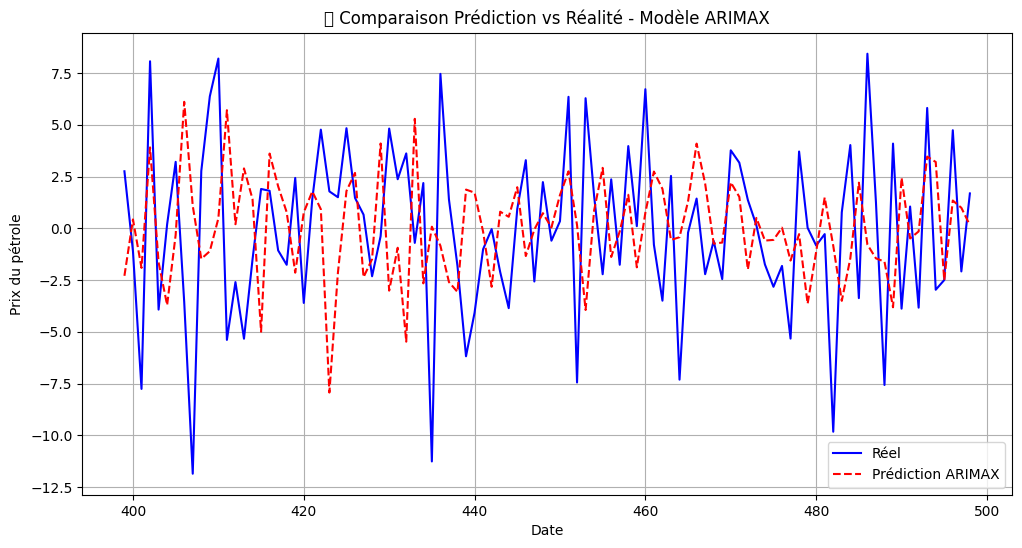

In [155]:
#Comparaison prédiciton-actual
plt.figure(figsize=(12,6))
plt.plot(df.index[train_size:], y_test, label="Réel", color="blue")
plt.plot(df.index[train_size:], y_pred, label="Prédiction ARIMAX", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Prix du pétrole")
plt.title("📉 Comparaison Prédiction vs Réalité - Modèle ARIMAX")
plt.legend()
plt.grid()
plt.show()

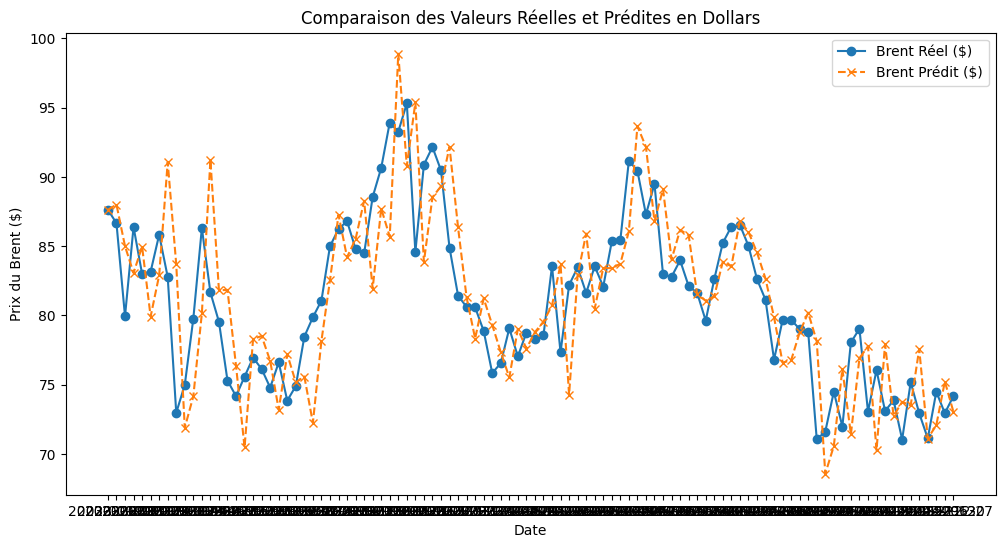

In [177]:
dates = lagged_df['Date'][train_size:].values
brent_real_values = final_df['Brent'][train_size+5:].values
y_pred_pct = y_pred.to_list()

brent_pred_values = [brent_real_values[0]]  # On commence par la première valeur réelle
for i in range(1, len(y_pred_pct)):
    a = brent_real_values[i-1]
    b = (1 + y_pred_pct[i] / 100)
    brent_pred_values.append( a* b)  # Appliquer la variation %

# Création d'un DataFrame pour stocker les valeurs réelles et prédites
df_comparison = pd.DataFrame({
    "Date": dates,
    "Brent_réel ($)": brent_real_values,
    "Brent_prédit ($)": brent_pred_values
})

# Mettre la date comme index
df_comparison.set_index("Date", inplace=True)

# 📊 Affichage du graphique
plt.figure(figsize=(12, 6))
plt.plot(df_comparison.index, df_comparison["Brent_réel ($)"], label="Brent Réel ($)", linestyle='-', marker='o')
plt.plot(df_comparison.index, df_comparison["Brent_prédit ($)"], label="Brent Prédit ($)", linestyle='--', marker='x')

plt.xlabel("Date")
plt.ylabel("Prix du Brent ($)")
plt.title("Comparaison des Valeurs Réelles et Prédites en Dollars")
plt.legend()
# plt.show()

In [178]:
#Calcul des erreurs
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📊 Erreur MAE: {mae:.2f}")
print(f"📉 Erreur RMSE: {rmse:.2f}")

#calcul des erreurs en $
mae = mean_absolute_error(brent_real_values, brent_pred_values)
rmse = np.sqrt(mean_squared_error(brent_real_values, brent_pred_values))

print(f"📊 Erreur MAE $: {mae:.2f}")
print(f"📉 Erreur RMSE $: {rmse:.2f}")

📊 Erreur MAE: 4.15
📉 Erreur RMSE: 5.02
📊 Erreur MAE $: 3.34
📉 Erreur RMSE $: 4.11



##Regression linéaire



In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [243]:
#On prends uniquement comme données exogènes les données à partir de la précédente et on ajoute plusieurs lags
df = lagged_df

exogenous_cols = lagged_df.columns[23:]

target_col = "Brent"  # 🛢 Nom de la colonne à prédire

test_size = 0.2  # 📌 80/20 Split (20% Test)

df = df.sort_index()  # S'assurer que l'index est chronologique
train_size = int(len(df) * (1 - test_size))

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

y_train = train_df[target_col]
y_test = test_df[target_col]

X_train = train_df[exogenous_cols]
X_test = test_df[exogenous_cols]

#Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#entrainement du modèle et pred
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



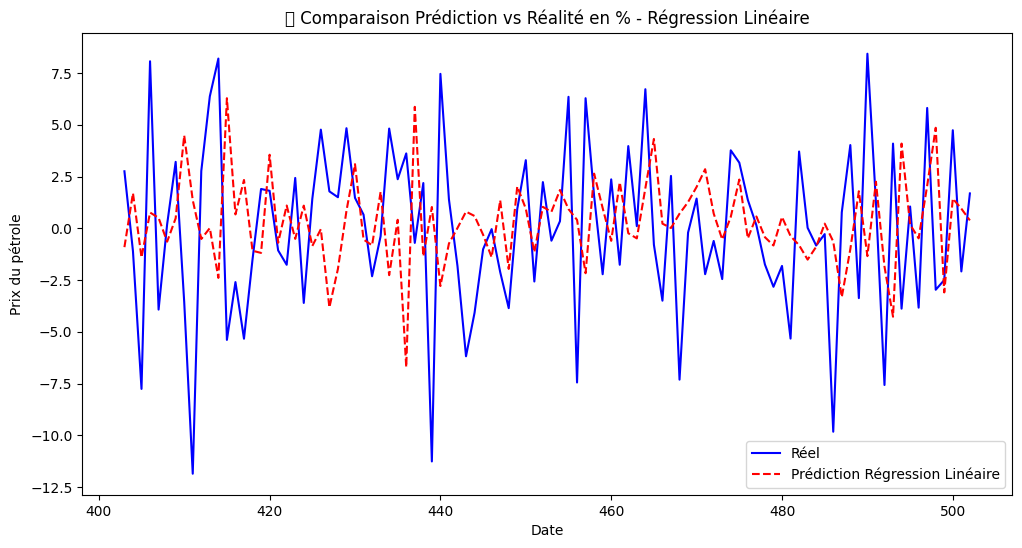

In [244]:
#Comparaison entre le modèles et la réalité
plt.figure(figsize=(12,6))
plt.plot(df.index[train_size:], y_test, label="Réel", color="blue")
plt.plot(df.index[train_size:], y_pred, label="Prédiction Régression Linéaire", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Prix du pétrole")
plt.title("📉 Comparaison Prédiction vs Réalité en % - Régression Linéaire")
plt.legend()
plt.show()

In [246]:
dates = lagged_df['Date'][train_size:].values
brent_real_values = final_df['Brent'][train_size+5:].values
y_pred_pct = y_pred

brent_pred_values = [brent_real_values[0]]  # On commence par la première valeur réelle
for i in range(1, len(y_pred_pct)):
    brent_pred_values.append(brent_real_values[i-1] * (1 + y_pred_pct[i] / 100))  # Appliquer la variation %

# Création d'un DataFrame pour stocker les valeurs réelles et prédites
df_comparison = pd.DataFrame({
    "Date": dates,
    "Brent_réel ($)": brent_real_values,
    "Brent_prédit ($)": brent_pred_values
})

# Mettre la date comme index
df_comparison.set_index("Date", inplace=True)



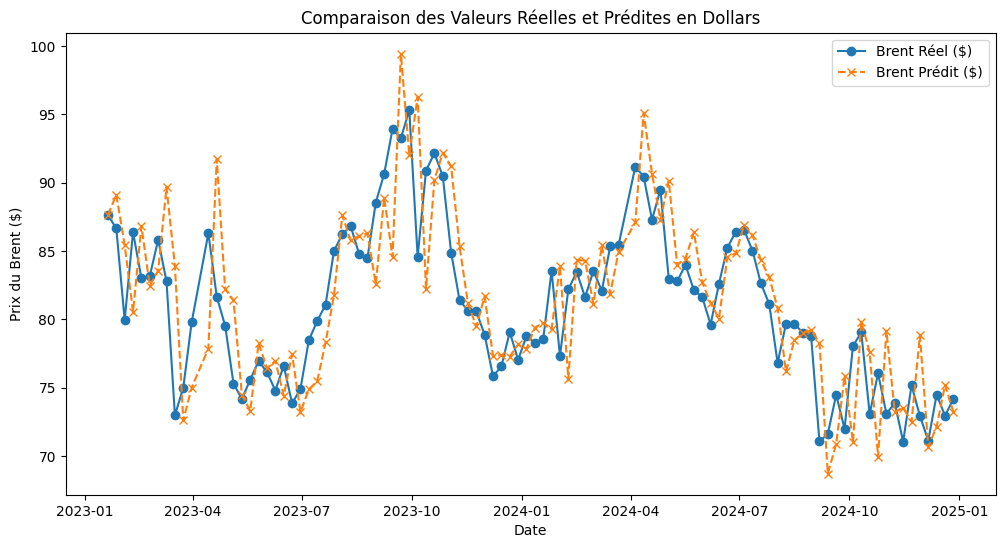

In [247]:
# 📊 Affichage du graphique
plt.figure(figsize=(12, 6))
plt.plot(df_comparison.index, df_comparison["Brent_réel ($)"], label="Brent Réel ($)", linestyle='-', marker='o')
plt.plot(df_comparison.index, df_comparison["Brent_prédit ($)"], label="Brent Prédit ($)", linestyle='--', marker='x')

plt.xlabel("Date")
plt.ylabel("Prix du Brent ($)")
plt.title("Comparaison des Valeurs Réelles et Prédites en Dollars")
plt.legend()
plt.show()

In [141]:
#calcul des erreurs %
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📊 Erreur MAE %: {mae:.2f}")
print(f"📉 Erreur RMSE % : {rmse:.2f}")

#calcul des erreurs en $
mae = mean_absolute_error(brent_real_values, brent_pred_values)
rmse = np.sqrt(mean_squared_error(brent_real_values, brent_pred_values))

print(f"📊 Erreur MAE $: {mae:.2f}")
print(f"📉 Erreur RMSE $: {rmse:.2f}")

📊 Erreur MAE %: 3.87
📉 Erreur RMSE % : 4.83
📊 Erreur MAE $: 3.13
📉 Erreur RMSE $: 3.98


## XGBoost

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [229]:
df = lagged_df
exogenous_cols = lagged_df.columns[23:]
target_col = "Brent"  # 🛢 Nom de la colonne à prédire
test_size = 0.2  # 📌 80/20 Split (20% Test)

df = df.sort_index()  # S'assurer que l'index est chronologique
train_size = int(len(df) * (1 - test_size))

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

y_train = train_df[target_col]
y_test = test_df[target_col]

X_train = train_df[exogenous_cols]
X_test = test_df[exogenous_cols]

# 📊 Standardiser les variables exogènes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Entrainement du modèle
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05, max_depth=5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



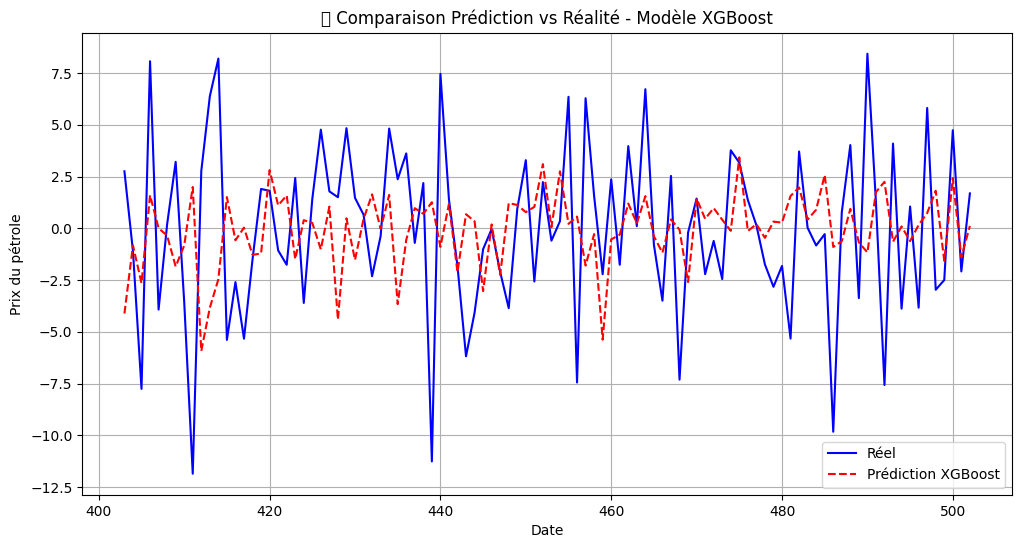

In [230]:
#Graphique comparaison
plt.figure(figsize=(12,6))
plt.plot(df.index[train_size:], y_test, label="Réel", color="blue")
plt.plot(df.index[train_size:], y_pred, label="Prédiction XGBoost", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Prix du pétrole")
plt.title("📉 Comparaison Prédiction vs Réalité - Modèle XGBoost")
plt.legend()
plt.grid()
plt.show()

In [231]:
dates = lagged_df['Date'][train_size:].values
brent_real_values = final_df['Brent'][train_size+5:].values
y_pred_pct = y_pred

brent_pred_values = [brent_real_values[0]]  # On commence par la première valeur réelle
for i in range(1, len(y_pred_pct)):
    brent_pred_values.append(brent_real_values[i-1] * (1 + y_pred_pct[i] / 100))  # Appliquer la variation %

# Création d'un DataFrame pour stocker les valeurs réelles et prédites
df_comparison = pd.DataFrame({
    "Date": dates,
    "Brent_réel ($)": brent_real_values,
    "Brent_prédit ($)": brent_pred_values
})

# Mettre la date comme index
df_comparison.set_index("Date", inplace=True)

# 📊 Affichage du graphique
plt.figure(figsize=(12, 6))
plt.plot(df_comparison.index, df_comparison["Brent_réel ($)"], label="Brent Réel ($)", linestyle='-', marker='o')
plt.plot(df_comparison.index, df_comparison["Brent_prédit ($)"], label="Brent Prédit ($)", linestyle='--', marker='x')

plt.xlabel("Date")
plt.ylabel("Prix du Brent ($)")
plt.title("Comparaison des Valeurs Réelles et Prédites en Dollars")
plt.legend()
plt.show()

ValueError: All arrays must be of the same length

In [147]:
#Calcul des erreurs
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train_scaled)))
print(f"📊 Erreur MAE (Train): {mae_train:.2f}")
print(f"📉 Erreur RMSE (Train): {rmse_train:.2f}")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📊 Erreur MAE: {mae:.2f}")
print(f"📉 Erreur RMSE: {rmse:.2f}")

#calcul des erreurs en $
mae = mean_absolute_error(brent_real_values, brent_pred_values)
rmse = np.sqrt(mean_squared_error(brent_real_values, brent_pred_values))

print(f"📊 Erreur MAE $: {mae:.2f}")
print(f"📉 Erreur RMSE $: {rmse:.2f}")

📊 Erreur MAE (Train): 1.45
📉 Erreur RMSE (Train): 2.05
📊 Erreur MAE: 3.63
📉 Erreur RMSE: 4.72
📊 Erreur MAE $: 2.93
📉 Erreur RMSE $: 3.83


In [105]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


# Séparation des caractéristiques et de la cible
X = df[lagged_df.columns[23:]]
y = df['Brent']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition du modèle XGBoost
model_xgb = XGBRegressor(
    n_estimators=15,
    learning_rate=0.2,
    max_depth=5,
    subsample=0.8,  # Utilisation de 80% des données pour chaque arbre
    #colsample_bytree=0.7,  # Utilisation de 70% des caractéristiques pour chaque arbre
    random_state=42,
    objective='reg:squarederror'
)

# Entraînement du modèle
model_xgb.fit(X_train, y_train)

# Prédictions
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

# Évaluation des performances d'entrainement et de test
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Affichage des métriques
print("Métriques d'entraînement:")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R²: {r2_train:.2f}")

print("\nMétriques de test:")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.2f}")

# Création du dataframe des résultats
results = pd.DataFrame({'real_sales': y_test, 'predicted_sales': y_pred_test})

# Importance des caractéristiques
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model_xgb.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nImportance des caractéristiques :")
print(feature_importances)


Métriques d'entraînement:
RMSE: 3.09
MAE: 2.42
R²: 0.69

Métriques de test:
RMSE: 5.44
MAE: 3.89
R²: -0.15

Importance des caractéristiques :
                                    Feature  Importance
3                                  WTI_lag1    0.065136
4                                  WTI_lag2    0.059555
45         Kerosene_Consumption_MBBL/D_lag1    0.042151
17          Distillate_Fuel_Oil_Stocks_lag3    0.038022
38        Residual_Fuel_Exports_MBBL/D_lag3    0.037577
47         Kerosene_Consumption_MBBL/D_lag3    0.034915
28            Crude_Oil_Imports_MBBL/D_lag2    0.032478
26            Crude_Oil_Exports_MBBL/D_lag3    0.027899
48    Residual_Fuel_Consumption_MBBL/D_lag1    0.027246
19                     Kerosene_Stocks_lag2    0.027006
52           Crude_Oil_refining_MBBL/D_lag2    0.025656
7                              EUR/USD_lag2    0.025393
30      Distillate_Fuel_Exports_MBBL/D_lag1    0.025244
2                                Brent_lag3    0.024444
5                 

In [106]:
import plotly.express as px
import pandas as pd

# Création du DataFrame avec les importances des variables
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_xgb.feature_importances_
})

# Trier par importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Création du graphique en barres avec Plotly
fig = px.bar(feature_importances,
             x="Importance",
             y="Feature",
             orientation='h',
             title="Importance des caractéristiques",
             labels={'Feature': 'Variables', 'Importance': 'Score d\'importance'},
             color_discrete_sequence=['blue'])

# Afficher la figure
fig.show()

##XGboost pour prévoir la dernière valeur

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

def xgboost_pipe (df):
  exogenous_cols = df.columns[23:]
  target_col = "Brent"  # 🛢 Nom de la colonne à prédire
  df = df.sort_index()  # S'assurer que l'index est chronologique
  train_size = len(df) - 1

  train_df = df.iloc[:train_size]
  test_df = df.iloc[train_size:]

  y_train = train_df[target_col]
  y_test = test_df[target_col]

  X_train = train_df[exogenous_cols]
  X_test = test_df[exogenous_cols]

  # 📊 Standardiser les variables exogènes
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #Entrainement du modèle
  model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05, max_depth=5)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)

  return y_pred.item()

#Pipeline complet avec XGBoost

In [ ]:
# téléchargement & traitement
final_df =table_complete(start="2015-01-01", end="2025-01-01")
df_diff = diff(final_df)
lagged_df = add_lags(df_diff, col_lag, num_lags=3).iloc[4:]

In [251]:
#prédiction de la dernière valeur avec XGBoost
var = xgboost_pipe(lagged_df)
pred = final_df['Brent'][-1] * (1 + var/ 100)

74.97375142846694


<ipython-input-251-637f6d06663d>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [261]:
#Pipeline entier
def prediction_prix (date = '2025-01-01'):
  final_df =table_complete(start="2015-01-01", end = date)
  df_diff = diff(final_df)
  lagged_df = add_lags(df_diff, col_lag, num_lags=3).iloc[4:]
  var = xgboost_pipe(lagged_df)
  pred = final_df['Brent'][-1] * (1 + var/ 100)
  print (f'Prédiction de prix pour le {date} : {round (pred,3)} $')

#Fonction générale pour prédire le prix à une date

In [262]:
prediction_prix (date = '2024-07-02')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-38-9bf75c070ea9>:15: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Prédiction de prix pour le 2024-07-02 : 85.877 $


<ipython-input-261-57dd29dbeb5c>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

